In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord

import utils
import model_spectra as NN
import fitting

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# Check label recovery 

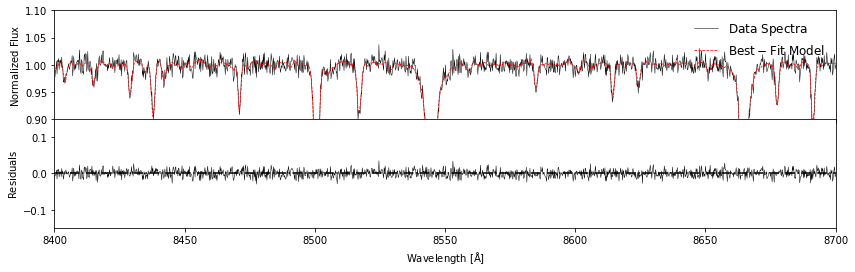

Best Fit Labels:
[-0.01 -1.98 -2.00 -1.99 -1.95 -2.01 -1.98 -1.99 4113.06 0.51 9.96]
True Labels:
[0.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 4100.00 0.50 10.00]


In [2]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Generate a spectrum from labels and NN
feh = -2.0
alphafe = 0.0
alpha = alphafe + feh
Teff = 4100
logg = 0.5
dv = 10
real_labels = np.array([alphafe, alpha, alpha, alpha, alpha, alpha, alpha,
                        feh, Teff, logg, dv])
real_spec = NN.get_spectrum_from_neural_net(labels=real_labels, NN_coeffs=NN_coeffs)
data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
spec_err = 0.01 * np.ones(len(wavelength))

# Apply Mask
kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
spec_err[mask] = 1e16

# Fit spectrum
popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)

# zoom in on a small region of the spectrum so we can see what's going on.
lambda_min, lambda_max = 8400, 8700# for plotting 
m = (wavelength < lambda_max) & (wavelength > lambda_min)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 4))

ax1.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.75, label = r'$\mathrm{Best-Fit\ Model}$')
ax1.set_xlim(lambda_min, lambda_max)
ax1.set_ylim(0.90,1.10)
ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
ax1.legend(loc = 'best', frameon = False, fontsize = 12)

ax2.plot(wavelength[m], data_spec[m]-model_spec[m], 'k', lw=0.5)
ax2.hlines(0, lambda_min, lambda_max, linestyles='-.')
ax2.set_ylim(-0.15,0.15)
ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
ax2.set_ylabel(r'$\mathrm{Residuals}$')

fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()


print('Best Fit Labels:')
print(popt)

print('True Labels:')
print(real_labels)

# Fitting Spectra from the Training Set

In [3]:
D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/synth_spectra/'
SpectraFile = 'convolved_synthetic_spectra_MIST.npz'
temp = np.load(SpectraDir + SpectraFile)
spectra = temp['spectra']
norm_spectra = temp['norm_spectra_approx']
labels = temp['labels']
temp.close()

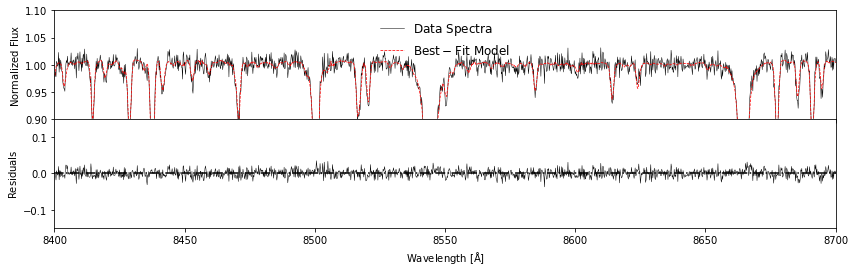

Best Fit Labels:
[0.49 -1.45 -1.47 -1.47 -1.49 -1.47 -1.45 -1.95 3662.58 1.00 0.34]
True Labels:
[0.40 -1.60 -1.60 -1.60 -1.60 -1.60 -1.60 -2.00 3618.24 0.67 0.00]


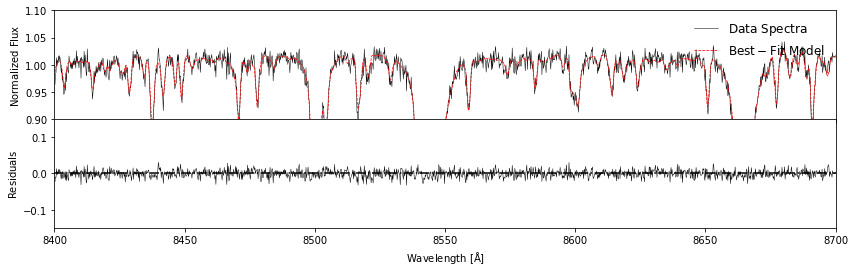

Best Fit Labels:
[0.40 0.12 0.13 0.16 0.15 0.13 0.18 -0.24 5366.25 2.50 0.24]
True Labels:
[0.40 0.15 0.15 0.15 0.15 0.15 0.15 -0.25 5358.48 2.42 0.00]


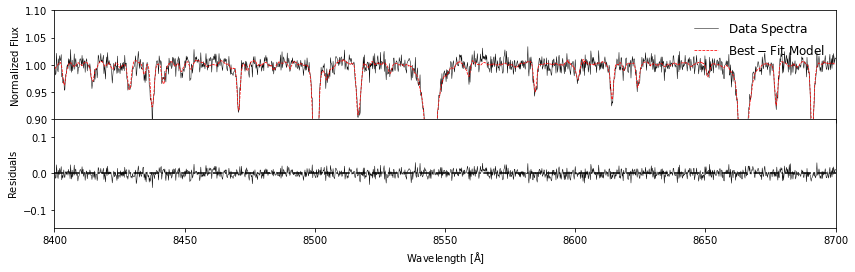

Best Fit Labels:
[-0.20 -1.67 -1.69 -1.69 -1.71 -1.70 -1.70 -1.46 4409.09 1.24 0.07]
True Labels:
[-0.20 -1.70 -1.70 -1.70 -1.70 -1.70 -1.70 -1.50 4412.10 1.21 0.00]


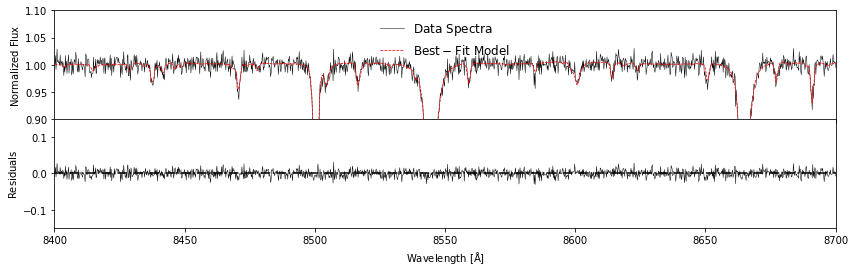

Best Fit Labels:
[0.39 -1.14 -1.08 -1.09 -1.13 -1.11 -1.11 -1.48 5340.22 3.01 0.22]
True Labels:
[0.40 -1.10 -1.10 -1.10 -1.10 -1.10 -1.10 -1.50 5344.53 3.02 0.00]


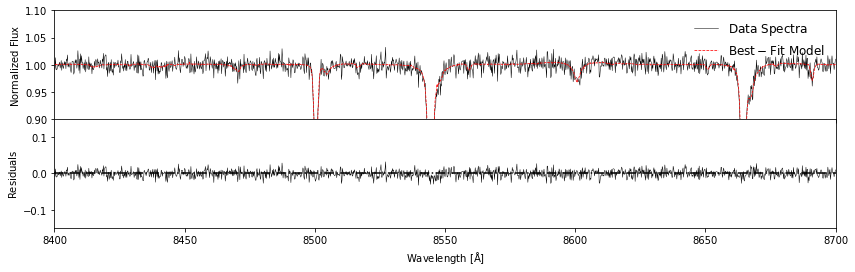

Best Fit Labels:
[0.70 -1.78 -1.78 -1.74 -1.78 -1.78 -1.74 -2.43 5737.97 3.67 0.35]
True Labels:
[0.80 -1.70 -1.70 -1.70 -1.70 -1.70 -1.70 -2.50 5740.90 3.64 0.00]


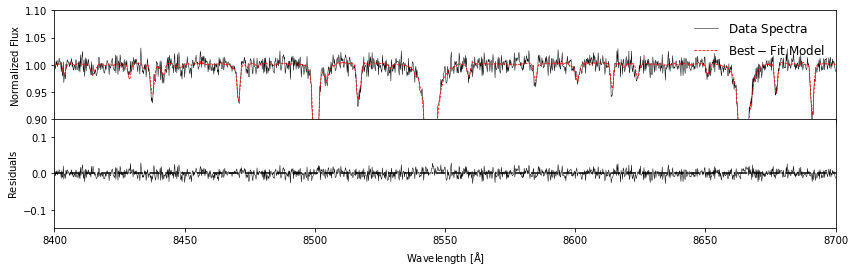

Best Fit Labels:
[0.16 -1.71 -1.62 -1.69 -1.67 -1.70 -1.70 -1.83 4557.83 1.25 0.49]
True Labels:
[0.00 -1.50 -1.50 -1.50 -1.50 -1.50 -1.50 -1.50 4790.79 1.92 0.00]


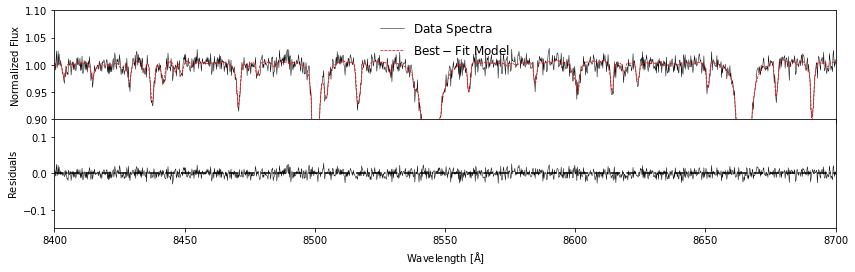

Best Fit Labels:
[0.21 -0.82 -0.82 -0.74 -0.81 -0.78 -0.79 -0.98 5062.18 2.34 -0.02]
True Labels:
[0.20 -0.80 -0.80 -0.80 -0.80 -0.80 -0.80 -1.00 5072.15 2.34 0.00]


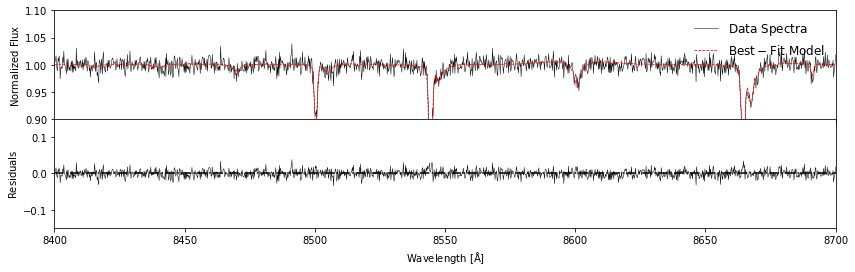

Best Fit Labels:
[-0.02 -2.51 -2.54 -2.45 -2.51 -2.54 -2.41 -2.45 5981.56 3.75 -0.55]
True Labels:
[-0.20 -2.70 -2.70 -2.70 -2.70 -2.70 -2.70 -2.50 5947.54 3.63 0.00]


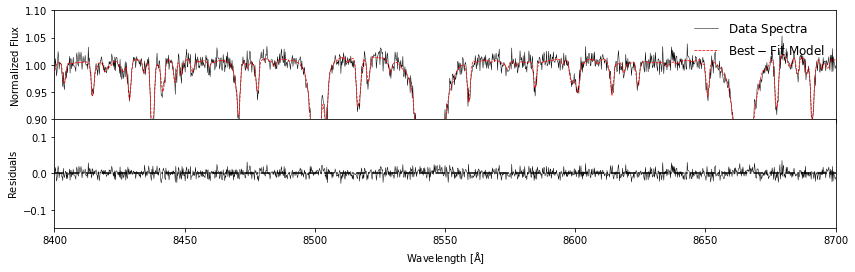

Best Fit Labels:
[0.78 -0.23 -0.18 -0.18 -0.19 -0.20 -0.19 -0.96 4829.58 1.81 0.16]
True Labels:
[0.80 -0.20 -0.20 -0.20 -0.20 -0.20 -0.20 -1.00 4817.72 1.85 0.00]


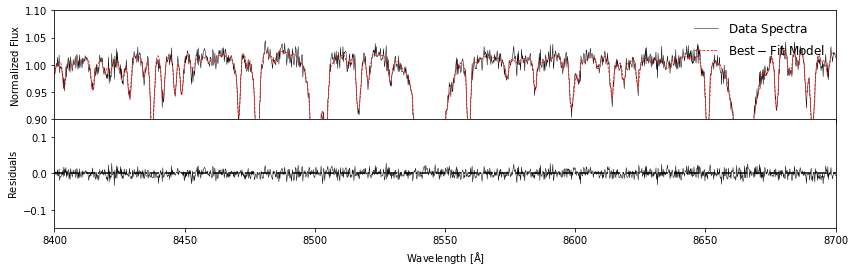

Best Fit Labels:
[0.60 0.62 0.61 0.59 0.58 0.58 0.62 0.01 5665.28 4.46 0.15]
True Labels:
[0.60 0.60 0.60 0.60 0.60 0.60 0.60 0.00 5679.74 4.47 0.00]


In [4]:
# Samples 10 spectra randomly from the training set
n = np.random.randint(0,len(norm_spectra),10)

for i, spec in enumerate(norm_spectra[n]):
    j = n[i]
    real_labels = np.append(labels[j],0.0)
    real_spec = spec
    data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
    spec_err = 0.01 * np.ones(len(real_spec))
    
    # Apply Mask
    kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
    mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
    spec_err[mask] = 1e16
    
    # Restore NN
    NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

    # Fit spectrum
    popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)

    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min, lambda_max = 8400, 8700# for plotting 
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 4))
    
    ax1.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
    ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.75, label = r'$\mathrm{Best-Fit\ Model}$')
    ax1.set_xlim(lambda_min, lambda_max)
    ax1.set_ylim(0.90,1.10)
    ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
    ax1.legend(loc = 'best', frameon = False, fontsize = 12)
    
    ax2.plot(wavelength[m], data_spec[m]-model_spec[m], 'k', lw=0.5)
    ax2.hlines(0, lambda_min, lambda_max, linestyles='-.')
    ax2.set_ylim(-0.15,0.15)
    ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax2.set_ylabel(r'$\mathrm{Residuals}$')
    
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
    
    print('Best Fit Labels:')
    print(popt)
    
    print('True Labels:')
    print(real_labels)

# Fitting Real Spectra

In [5]:
wavelength = utils.load_wavelength_array()

D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/M15/'
SpectraFile = 'm15_Horne.npz'
temp = np.load(SpectraDir + SpectraFile)
obj = temp['obj']
spec = temp['spec']
spectral_err = temp['spec_err']
dv = temp['dv']
RA_Dec = SkyCoord(temp['RA_Dec'])
temp.close()

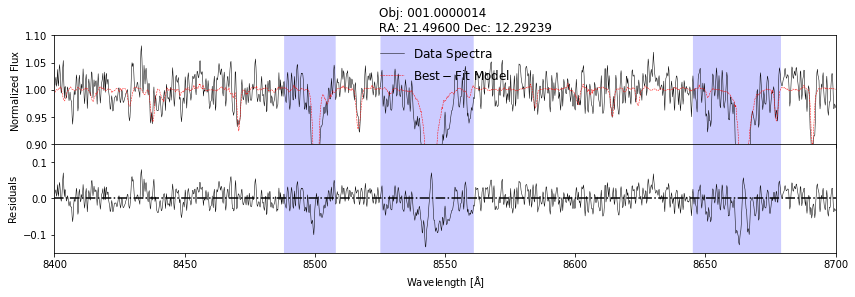

Best Fit Labels:
[-0.01 -1.97 -2.02 -2.00 -2.02 -2.04 -1.98 -2.04 4329.30 0.57 2.89]


In [10]:
# Samples 5 spectra randomly from the training set
n = [1]

for i in range(len(spec[n])):
    j = n[i]
    norm_spec = spec[j]
    spec_err = spectral_err[j]
    
    # Apply Mask
    kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
    mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
    spec_err[mask] = 1e16
    
    # Restore NN
    NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')
    
    # Fit spectrum
    p0 = [0, -2, -2, -2, -2, -2, -2,
          -2, 4100, 0.5, 0]
    popt, pcov, model_spec \
        = fitting.fit_normalized_spectrum_single_star_model(norm_spec = norm_spec,
                                                            spec_err = spec_err,
                                                            NN_coeffs = NN_coeffs,
                                                            p0 = p0, num_p0 = 10)

    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min, lambda_max = 8400, 8700# for plotting 
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 4))
    
    ax1.plot(wavelength[m], norm_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
    ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = r'$\mathrm{Best-Fit\ Model}$')
    ax1.fill(wavelength[m], spec_err[m]/1e16+0.1, "b", alpha=0.2)
    ax1.set_xlim(lambda_min, lambda_max)
    ax1.set_ylim(0.90,1.10)
    ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
    ax1.legend(loc = 'best', frameon = False, fontsize = 12)
    
    ax2.plot(wavelength[m], norm_spec[m]-model_spec[m], 'k', lw=0.5)
    ax2.fill(wavelength[m], spec_err[m]/1e16-0.85, "b", alpha=0.2)
    ax2.hlines(0, lambda_min, lambda_max, linestyles='-.')
    ax2.set_ylim(-0.15,0.15)
    ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax2.set_ylabel(r'$\mathrm{Residuals}$')
    
    plt.suptitle('Obj: %s\n\
                 RA: %.5f Dec: %.5f' % (obj[j], RA_Dec[j].ra.deg, RA_Dec[j].dec.deg))
    
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
    
    print('Best Fit Labels:')
    print(popt)

# Exploring LF w/ emcee

In [8]:
def lnlike(labels, data, data_err):
    model_spec = NN.get_spectrum_from_neural_net(labels=labels, NN_coeffs=NN_coeffs)
    lnchi2 = np.sum((data_spec - model_spec)**2/data_err**2)
    return(lnchi2)


def lnprior(labels):
    if theta[-4] < -1:
        return(1)
    else:
        return(-np.inf)


def lnprob(labels, data, data_err):
    lp = lnprior(labels)
    if not np.isfinite(lp):
        return(-np.inf)
    else:
        return(lp + lnlike(labels, data, data_err))

In [11]:
ndim, nwalkers = len(popt), 100
p0 = [popt + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(norm_spec, spec_err))
sampler.run_mcmc(p0,500)

[array([-0.02, -1.97, -2.00, -1.99, -2.00, -2.03, -1.97, -2.03, 4329.28,
        0.58, 2.88]),
 array([-0.01, -1.96, -2.01, -2.00, -2.02, -2.04, -1.96, -2.03, 4329.29,
        0.55, 2.89]),
 array([-0.03, -1.97, -2.02, -1.99, -2.01, -2.05, -1.97, -2.04, 4329.32,
        0.55, 2.88]),
 array([-0.02, -1.95, -2.00, -1.99, -2.04, -2.05, -1.97, -2.05, 4329.29,
        0.56, 2.87]),
 array([-0.01, -1.97, -2.02, -1.97, -2.02, -2.04, -1.97, -2.04, 4329.31,
        0.58, 2.88]),
 array([-0.03, -1.98, -2.01, -2.01, -2.01, -2.05, -1.99, -2.05, 4329.31,
        0.55, 2.88]),
 array([-0.02, -1.94, -2.02, -2.01, -2.00, -2.04, -1.98, -2.04, 4329.29,
        0.56, 2.89]),
 array([-0.04, -1.95, -2.02, -2.00, -2.03, -2.05, -1.98, -2.04, 4329.29,
        0.56, 2.88]),
 array([-0.00, -1.97, -2.03, -1.99, -2.02, -2.03, -1.98, -2.03, 4329.28,
        0.57, 2.89]),
 array([-0.01, -1.95, -2.00, -2.00, -2.00, -2.05, -1.98, -2.04, 4329.31,
        0.57, 2.89]),
 array([-0.01, -1.97, -2.02, -2.00, -2.02, -2.05, 